# Práctica 2 — Reinforcement Learning (Taxi-v3)

**Autor:** Jordi Blasco Lozano  
**Asignatura:** Agentes Inteligentes

### Índice
1. Resumen
2. Configuración y utilidades
3. Ejercicio 1: política aleatoria (Random Walk)
4. Ejercicio 2: SARSA
5. Comparativa final y conclusiones


## 1. Resumen

En esta práctica implemento y comparo dos enfoques sobre **Taxi-v3**:

- Un agente sin aprendizaje (acciones aleatorias), como baseline.
- Un agente entrenado con **SARSA** (método on-policy de control por valor).

Para ambos casos recojo las métricas pedidas en el enunciado:

- **Recompensa acumulada** por episodio.
- **Número de timesteps** por episodio.
- **Número de penalizaciones** (acciones ilegales de recoger/dejar pasajero).

También incluyo funciones para generar GIFs de episodios representativos.


## 2. Configuración y utilidades

In [2]:
# Si necesitas instalar dependencias, descomenta y ejecuta:
# !pip install "gymnasium[toy-text]" numpy matplotlib moviepy IPython pandas

import random
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Dict, List, Tuple

import gymnasium as gym
import moviepy as mp
from IPython.display import Image

plt.style.use("seaborn-v0_8")
np.set_printoptions(precision=4, suppress=True)


In [3]:
def save_gif(frames, filename, fps=10):
    """Crea y serializa un GIF a partir de una lista de frames RGB."""
    clip = mp.ImageSequenceClip(frames, fps=fps)
    clip.write_gif(filename, fps=fps)


def summarize_metrics(metrics: Dict[str, List[float]]) -> Dict[str, Tuple[float, float]]:
    """Devuelve media y desviación típica para cada métrica."""
    return {
        key: (float(np.mean(values)), float(np.std(values)))
        for key, values in metrics.items()
    }


def print_summary(title: str, summary: Dict[str, Tuple[float, float]]):
    print(f"\n{title}")
    print("-" * len(title))
    for metric, (mean, std) in summary.items():
        print(f"{metric:>20}: media = {mean:8.3f} | std = {std:8.3f}")


def plot_metrics(metrics: Dict[str, List[float]], title_prefix: str):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    names = ["rewards", "timesteps", "penalties"]
    labels = ["Recompensa acumulada", "Timesteps", "Penalizaciones"]

    for ax, name, label in zip(axes, names, labels):
        ax.plot(metrics[name], alpha=0.9)
        ax.set_title(f"{title_prefix} — {label}")
        ax.set_xlabel("Episodio")
        ax.set_ylabel(label)

    plt.tight_layout()
    plt.show()


## 3. Ejercicio 1: política aleatoria (Random Walk)

En esta sección evalúo durante **100 episodios** una política completamente aleatoria.

Además, implemento una variante opcional con **action masking** para muestrear solo acciones legales cuando el entorno lo permite.

In [4]:
@dataclass
class EpisodeResult:
    reward: float
    timesteps: int
    penalties: int


def run_random_episode(env, use_action_mask=False, capture_frames=False, max_steps=200):
    state, info = env.reset()

    total_reward = 0
    penalties = 0
    frames = []

    for t in range(1, max_steps + 1):
        if use_action_mask and "action_mask" in info:
            valid_actions = np.flatnonzero(info["action_mask"])
            action = int(np.random.choice(valid_actions))
        else:
            action = env.action_space.sample()

        next_state, reward, terminated, truncated, info = env.step(action)

        if reward == -10:
            penalties += 1

        total_reward += reward
        state = next_state

        if capture_frames:
            frame = env.render()
            if frame is not None:
                frames.append(frame)

        if terminated or truncated:
            return EpisodeResult(total_reward, t, penalties), frames

    return EpisodeResult(total_reward, max_steps, penalties), frames


def evaluate_random_policy(n_episodes=100, use_action_mask=False, seed=42):
    random.seed(seed)
    np.random.seed(seed)

    env = gym.make("Taxi-v3", render_mode="rgb_array")

    metrics = {"rewards": [], "timesteps": [], "penalties": []}

    for _ in range(n_episodes):
        result, _ = run_random_episode(env, use_action_mask=use_action_mask)
        metrics["rewards"].append(result.reward)
        metrics["timesteps"].append(result.timesteps)
        metrics["penalties"].append(result.penalties)

    gif_result, gif_frames = run_random_episode(
        env,
        use_action_mask=use_action_mask,
        capture_frames=True,
    )

    env.close()
    return metrics, gif_result, gif_frames


C:\Users\jordi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists



Política aleatoria (sin action mask)
------------------------------------
             rewards: media = -771.400 | std =   78.053
           timesteps: media =  199.060 | std =    6.795
           penalties: media =   63.640 | std =    8.270


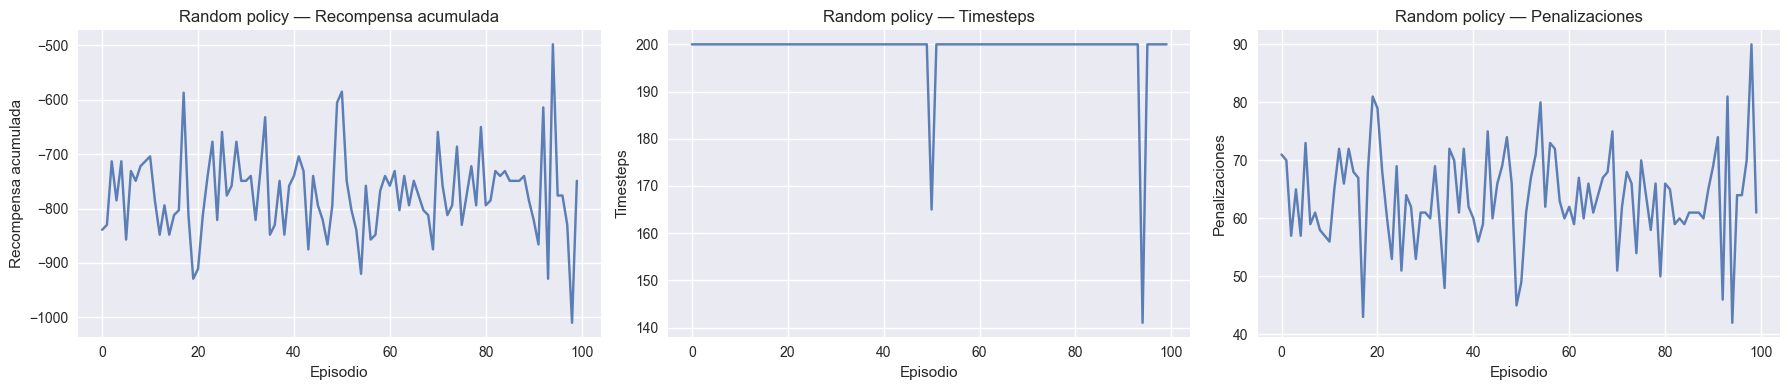

In [5]:
random_metrics, random_gif_result, random_frames = evaluate_random_policy(
    n_episodes=100,
    use_action_mask=False,
    seed=123,
)

random_summary = summarize_metrics(random_metrics)
print_summary("Política aleatoria (sin action mask)", random_summary)
plot_metrics(random_metrics, "Random policy")


MoviePy - Building file random_policy.gif with imageio.


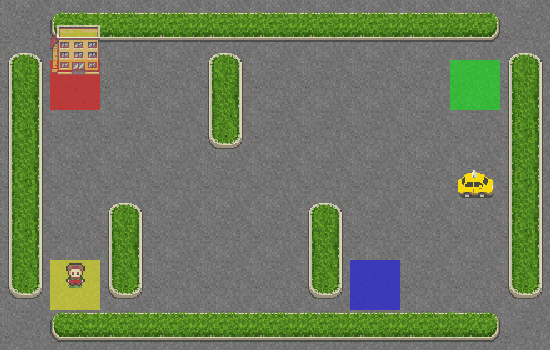

In [6]:
random_gif_path = "random_policy.gif"
save_gif(random_frames, random_gif_path, fps=8)
Image(filename=random_gif_path)



Política aleatoria (con action mask)
------------------------------------
             rewards: media = -186.150 | std =   35.858
           timesteps: media =  189.510 | std =   29.264
           penalties: media =    0.000 | std =    0.000


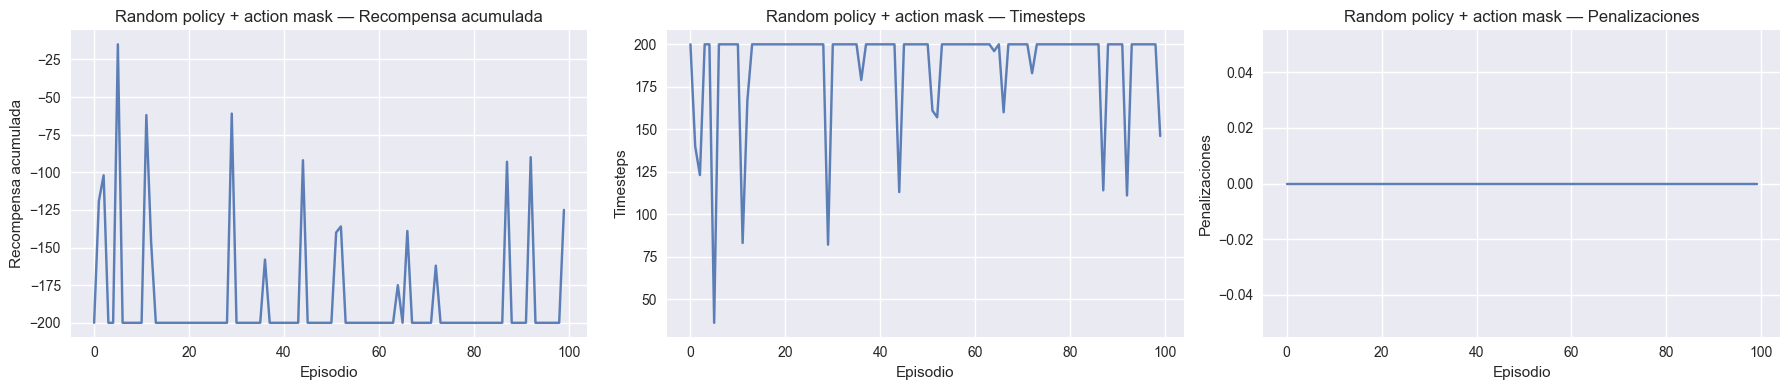

In [7]:
masked_metrics, masked_gif_result, masked_frames = evaluate_random_policy(
    n_episodes=100,
    use_action_mask=True,
    seed=123,
)

masked_summary = summarize_metrics(masked_metrics)
print_summary("Política aleatoria (con action mask)", masked_summary)
plot_metrics(masked_metrics, "Random policy + action mask")


## 4. Ejercicio 2: SARSA

Implemento SARSA con estrategia **$\epsilon$-greedy** para entrenar una tabla $Q$ de tamaño `(500, 6)`.

Hiperparámetros base (ajustables):

- `alpha = 0.1` (learning rate)
- `gamma = 0.99` (discount factor)
- `epsilon_start = 1.0`, `epsilon_min = 0.05`, `epsilon_decay = 0.995`


In [8]:
def epsilon_greedy_action(q_table, state, epsilon, action_space_n):
    if np.random.random() < epsilon:
        return np.random.randint(action_space_n)
    return int(np.argmax(q_table[state]))


def train_sarsa(
    n_episodes=5000,
    alpha=0.1,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_min=0.05,
    epsilon_decay=0.995,
    max_steps=200,
    seed=42,
):
    random.seed(seed)
    np.random.seed(seed)

    env = gym.make("Taxi-v3")
    n_states = env.observation_space.n
    n_actions = env.action_space.n

    q_table = np.zeros((n_states, n_actions), dtype=np.float32)

    metrics = {"rewards": [], "timesteps": [], "penalties": []}
    epsilon = epsilon_start

    for _ in range(n_episodes):
        state, _ = env.reset()
        action = epsilon_greedy_action(q_table, state, epsilon, n_actions)

        total_reward = 0
        penalties = 0

        for t in range(1, max_steps + 1):
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_action = epsilon_greedy_action(q_table, next_state, epsilon, n_actions)

            td_target = reward + gamma * q_table[next_state, next_action]
            td_error = td_target - q_table[state, action]
            q_table[state, action] += alpha * td_error

            if reward == -10:
                penalties += 1

            total_reward += reward
            state, action = next_state, next_action

            if terminated or truncated:
                break

        metrics["rewards"].append(total_reward)
        metrics["timesteps"].append(t)
        metrics["penalties"].append(penalties)

        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    env.close()
    return q_table, metrics


def evaluate_greedy_policy(q_table, n_episodes=100, max_steps=200, seed=123, capture_gif=True):
    random.seed(seed)
    np.random.seed(seed)

    env = gym.make("Taxi-v3", render_mode="rgb_array")
    metrics = {"rewards": [], "timesteps": [], "penalties": []}
    gif_frames = []

    for ep in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        penalties = 0
        local_frames = []

        for t in range(1, max_steps + 1):
            action = int(np.argmax(q_table[state]))
            next_state, reward, terminated, truncated, _ = env.step(action)

            if reward == -10:
                penalties += 1

            total_reward += reward
            state = next_state

            if capture_gif and ep == 0:
                frame = env.render()
                if frame is not None:
                    local_frames.append(frame)

            if terminated or truncated:
                break

        metrics["rewards"].append(total_reward)
        metrics["timesteps"].append(t)
        metrics["penalties"].append(penalties)

        if capture_gif and ep == 0:
            gif_frames = local_frames

    env.close()
    return metrics, gif_frames



SARSA - entrenamiento
---------------------
             rewards: media =  -30.670 | std =  118.649
           timesteps: media =   30.613 | std =   45.241
           penalties: media =    2.231 | std =    8.311


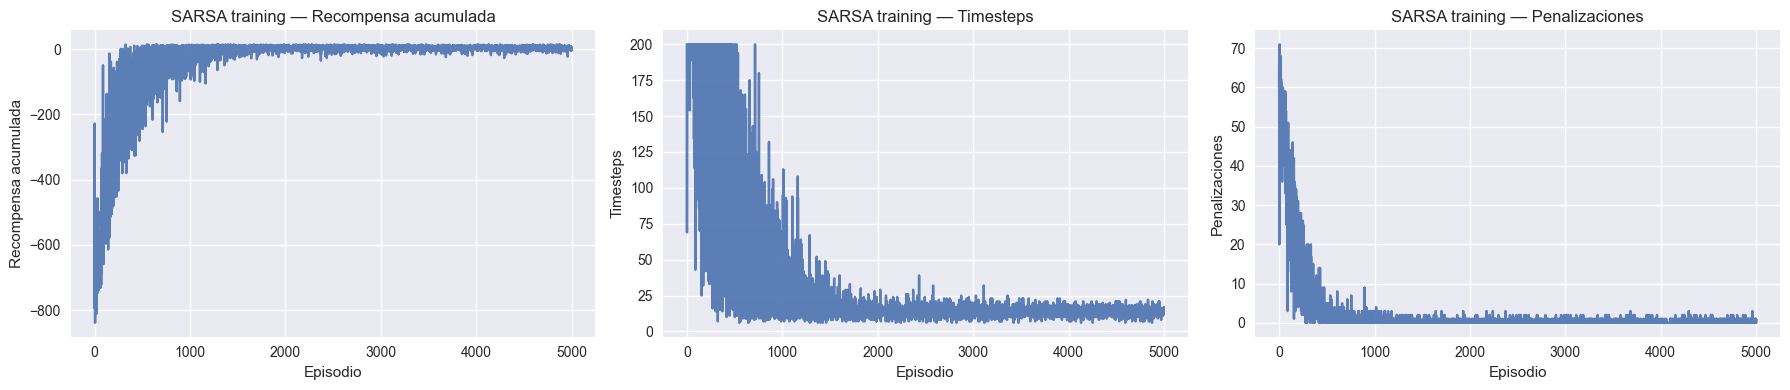

In [9]:
q_table, sarsa_train_metrics = train_sarsa(
    n_episodes=5000,
    alpha=0.1,
    gamma=0.99,
    epsilon_start=1.0,
    epsilon_min=0.05,
    epsilon_decay=0.995,
    max_steps=200,
    seed=123,
)

train_summary = summarize_metrics(sarsa_train_metrics)
print_summary("SARSA - entrenamiento", train_summary)
plot_metrics(sarsa_train_metrics, "SARSA training")



SARSA - evaluación (política greedy)
------------------------------------
             rewards: media =    8.040 | std =    2.596
           timesteps: media =   12.960 | std =    2.596
           penalties: media =    0.000 | std =    0.000


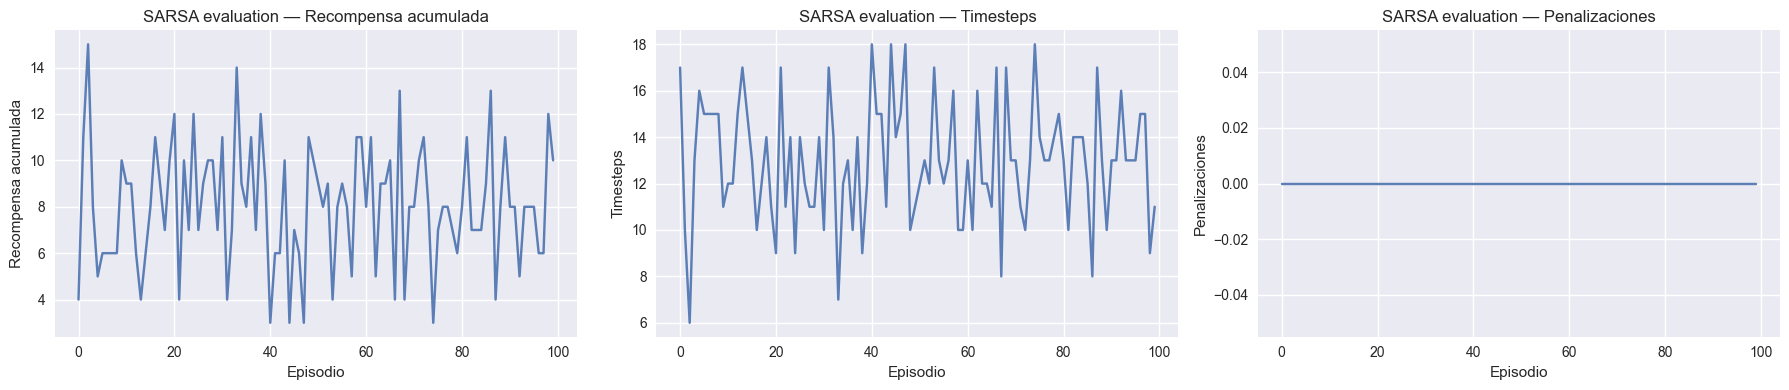

In [10]:
sarsa_eval_metrics, learned_frames = evaluate_greedy_policy(
    q_table,
    n_episodes=100,
    max_steps=200,
    seed=123,
    capture_gif=True,
)

sarsa_eval_summary = summarize_metrics(sarsa_eval_metrics)
print_summary("SARSA - evaluación (política greedy)", sarsa_eval_summary)
plot_metrics(sarsa_eval_metrics, "SARSA evaluation")


MoviePy - Building file learned_policy.gif with imageio.


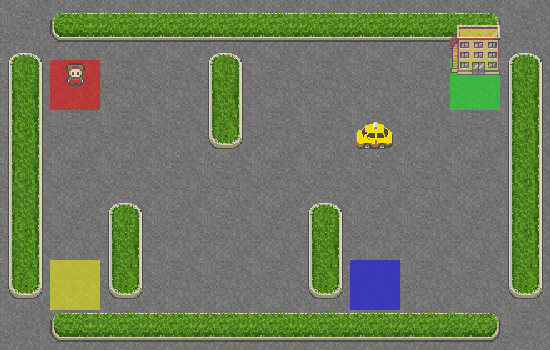

In [11]:
learned_gif_path = "learned_policy.gif"
save_gif(learned_frames, learned_gif_path, fps=8)
Image(filename=learned_gif_path)


## 5. Comparativa final y conclusiones

In [12]:
import pandas as pd

comparison = pd.DataFrame(
    {
        "Random": [
            random_summary["rewards"][0],
            random_summary["timesteps"][0],
            random_summary["penalties"][0],
        ],
        "Random + Mask": [
            masked_summary["rewards"][0],
            masked_summary["timesteps"][0],
            masked_summary["penalties"][0],
        ],
        "SARSA (eval)": [
            sarsa_eval_summary["rewards"][0],
            sarsa_eval_summary["timesteps"][0],
            sarsa_eval_summary["penalties"][0],
        ],
    },
    index=["Reward medio", "Timesteps medios", "Penalizaciones medias"],
)

comparison


,Random,Random + Mask,SARSA (eval)
Reward medio,-771.40,-186.15,8.04
Timesteps medios,199.06,189.51,12.96
Penalizaciones medias,63.64,0.00,0.00


### Discusión

- La política aleatoria presenta recompensas bajas, episodios largos y muchas penalizaciones.
- El action masking suele reducir penalizaciones, pero no aporta planificación global.
- SARSA aprende una política claramente superior: mejora recompensa media, reduce timesteps y minimiza acciones ilegales.

En conjunto, el aprendizaje basado en valor convierte el comportamiento del taxi de un paseo errático a una navegación dirigida por objetivo.
